<a href="https://colab.research.google.com/github/EddyGiusepe/Perceptron_with_Python/blob/main/The_Perceptron_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">O Perceptron: Classificação Multiclasse</h2>



Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este script está baseado no:

* Canal de YouTube de [Sensio](https://www.youtube.com/watch?v=8DEuF72Hyis&list=PLkgbkukKg_NpdJPhhHbemaWHNQCY-lmh1&index=9)

* [SENSIO - Inteligencia Artificial](https://juansensio.com/)

# Classificação Multiclasse

A arquitetura do Perceptron que até vimos nos a permitido realizar tarefas de: Regressão Linear e Classificação Binâria. Neste script vamos melhorar a implementação de nosso modelo para ser capaz de classificar várias classes. A arquitetura do perceptron é:


![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

<font color="orange">A ideia é a seguinte</font>: Se um percepetron é capaz de realizar uma tarefa de CLASSIFICAÇÃO BINÂRIA (identificar uma classe em particular de entre o resto), podemos utilizar tantos perceptrones como classe tenhamos. Nesta configuração, cada perceptron terá o objetivo de identificar uma das classes em particular do resto.

![](https://camo.githubusercontent.com/bcb4c2d2684739dd367e6e61d96102bb8ba28cd8/68747470733a2f2f6a6c6565776562626c6f672e66696c65732e776f726470726573732e636f6d2f323031372f30332f736f666d61782d72656772657373696f6e2e6a70673f773d36333326683d353237)

Nesta nova implementação, teremos tantas saídas como classes (podemos usar isto também para regressão, cada saída corresponderia a cada uma das grandezas de interés). Calculamos a saída do modelo da mesma maneira que no caso do perceptron de apenas uma saída. A diferença é que na última capa aplicaremos uma FUNÇÃO DE ATIVAÇÃO do tipo `SOFTMAX`. Isto nos fornecerá como resultado uma distribuição de probabilidade sobre todas as classes. Finalmente, atribuiremos aquela classe que tenha a probabilidade mais alta.


$$ \hat{y} = \underset{k}{\arg\max} \ \ \sigma(\mathbf{w} \cdot \mathbf{x})_k $$


No caso do Perceptron com uma saída, nosso pesos estavam representados por um vetor de comprimento igual ao número de entradas (mais um se levamos em conta o BIAS). Agora, ao ter várias saídas, os pesos estarão representados por uma matriz (tal como mostramos acima... é uma matriz de apenas uma coluna). Este modelo também se conhece pelo nome de `SOFTMAX REGRESSION`.


In [1]:
# Criamos nossa função SOFTMAX

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

Para treina o modelo com o algoritmo de `Descenso por gradiente` necesitamos uma `função de perda`, uma medida do error que nos sirva para otimizar os pesos. Neste caso utilizamos a função de perda conhecida como `Cross Entropy`.

$$ J(\mathbf{w}) = - \frac{1}{N} \sum^N_{j=1} \sum^K_{k=1} y_k^{(j)} log(\hat{y}_k^{(j)}) $$

onde $y_k^{(j)}$ é a probabilidad de que o elemento $j$ pertença à classe $k$ (normalmente $1$ ou $0$). Como podes observar, no caso que tenhamos apenas duas classes esta expressão é equivalente à função de perda que utilizamos para clasificación binaria no modelo de regresión logística, a função `Binary Cross Entropy`.

Como sempre, para poder aplicar o algoritmo, não só necesitamos a função de perda sinão tambén sua derivada com respeito aos pesos do modelo que queremos otimizar. Calculando a derivada da função anterior obtemos a seguinte expressão.

$$ \frac{\partial J_k}{\partial \mathbf{w}} =  \frac{1}{N} \sum^{N}_{j=1} (\hat{y}_k^{(j)} - y_k^{(j)}) \mathbf{x}^{(j)} $$

Por motivos de estabilidade numérica, é comum combinar a função `softmax` com a função `cross entropy` da seguinte maneira.

In [2]:
# Aplica softmax + cross entropy de maneira estável

def crossentropy(output, target):
    logits = output[np.arange(len(output)),target]
    entropy = - logits + np.log(np.sum(np.exp(output),axis=-1))
    return entropy


def grad_crossentropy(output, target):
    answers = np.zeros_like(output)
    answers[np.arange(len(output)),target] = 1    
    return (- answers + softmax(output)) / output.shape[0] # Isto é a Derivada

# Implementação

Aqui vamos a melhorar a implementação de nosso Perceptron para que seja capaz de classificar várias classes.

In [3]:
class Perceptron():
  def __init__(self, inputs, outputs):
    self.w = np.random.normal(loc=0.0, 
          scale = np.sqrt(2/(inputs+outputs)), 
          size = (inputs, outputs)) 
    self.ws = []
    self.loss = crossentropy
    self.grad_loss = grad_crossentropy
    
  def __call__(self, w, x):
    return np.dot(x, w) # Produto escalar pesos . inputs

  def fit(self, x, y, epochs, lr, verbose=True, log_each=1):
    x = np.c_[np.ones(len(x)), x]
    for epoch in range(1,epochs+1):
        # Batch Gradient Descent
        y_hat = self(self.w, x)  
        # Função de Perda
        l = self.loss(y_hat, y).mean()
        # Derivadas
        dldh = self.grad_loss(y_hat, y)
        dhdw = x
        dldw = np.dot(dhdw.T, dldh)
        # Atualizar pesos
        self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())
        # Print LOSS
        if verbose and not epoch % log_each:
            print(f"Epoch {epoch}/{epochs} Loss {l}")
            
  def predict(self, x):
    x = np.c_[np.ones(len(x)), x]
    return self(self.w, x)

# O Dataset Iris

Vamos testar nosso modelo com o conjunto de Dados do Iris.

In [4]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

y = iris.target

X.shape, y.shape

((150, 2), (150,))

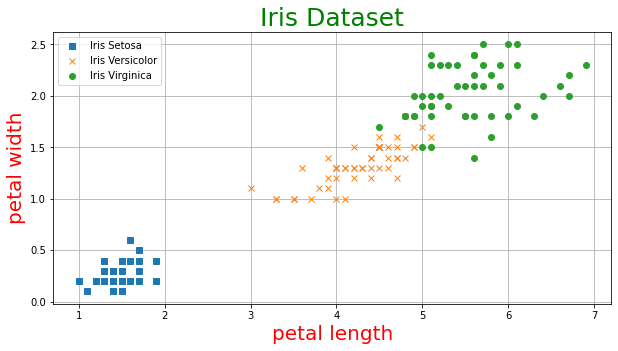

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(10, 5))

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=20, c='r')
plt.ylabel('petal width', fontsize=20, c='r')
plt.title("Iris Dataset", fontsize=25, c='green')
plt.show()

A diferença de exemplos passados, aqui vamos tentar classificar as três classes.

In [39]:
np.random.seed(42)

perceptron = Perceptron(3, 3) # 3 --> w0 (bias), w1 e w2 - 3 --> Três saídas (adotaremos aquela de maior probabilidade, mais para frente)
epochs, lr = 50, 1

perceptron.fit(X_norm, y, epochs, lr, log_each=10)

Epoch 10/50 Loss 0.3992838232798919
Epoch 20/50 Loss 0.290313203795845
Epoch 30/50 Loss 0.23774032243503038
Epoch 40/50 Loss 0.20631770086056744
Epoch 50/50 Loss 0.18530798162642056


In [40]:
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
rc('animation', html='html5')       
    
def animate(i, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
    X_new = np.c_[np.ones(len(X_new)), X_new]
    w = perceptron.ws[i]
    Z = perceptron(w, X_new)
    Z = np.argmax(softmax(Z), axis=1) 
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Como podemos observar nosso modelo está conseguindo separar as classes. Se tivessemos uma nova flor, podemos saber sua classe da seguinte forma:

In [42]:
# Novo ponto
X_new = [[2, 0.5]] # Uma nova Flor
# Normalizamos
X_new_norm = (X_new - X_mean) / X_std 
# Saída do Perceptron
y = perceptron.predict(X_new_norm)
y

array([[ 3.18405391,  1.31789892, -5.5272039 ]])

À saída do Perceptron aplicamos a função `SOFTMAX` para obter uma distribuição de Probabilidade.  

In [43]:
y_probas = softmax(y)
y_probas


array([[8.65889231e-01, 1.33968139e-01, 1.42630085e-04]])

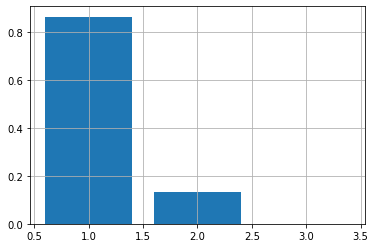

In [46]:
plt.bar(list(range(1,4)), y_probas[0])
plt.grid(True)
plt.show()

# Neste caso pertence à classe 1

Numa distribuição de probabilidade, a soma de todas as probabilidades soma $1$.


In [47]:
y_probas.sum(axis=1)


array([1.])

<font color="orange">Agora atribuiremos para esse elemento, essa flor, a MAIOR PROBABILIDADE.</font>

In [50]:
y_pred = np.argmax(y_probas, axis=1)

y_pred

# Lembrar que o índice começa com 0... ou seja classe 1.  array([0]) --> classe 1.

array([0])

Podemos provar varios pontos:

In [51]:
def evaluate(x):
    x = (x - X_mean) / X_std 
    y = perceptron.predict(x)
    y_probas = softmax(y)
    return np.argmax(y_probas, axis=1)

In [54]:
X = [[5, 1],[2, 0.5],[7, 3]]

evaluate(X)

# Cuidado com os ÍNDICES
# array([1, 0, 2])--> CLASSE 2, CLASSE 1, CLASSE 3

array([1, 0, 2])

# O Dataset MNIST

Agora classificaremos dígitos manuscritos com o Dataset MNIST.

In [55]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

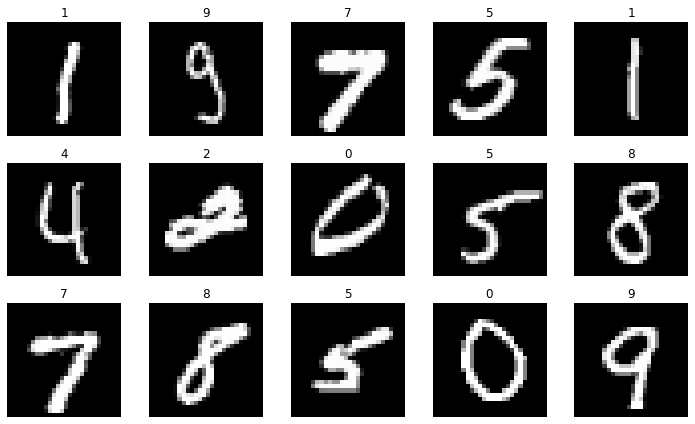

In [61]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import random 


r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X.loc[ix].to_numpy()
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

In [62]:
# Normalizamos os Dados

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)

In [63]:
# Treinamos um Perceptron para classificação em 10 classes a partir dos pixeis de cada imagem.

perceptron = Perceptron(785, 10)
epochs, lr = 200, 1

perceptron.fit(X_train, y_train, epochs, lr, log_each=10)

Epoch 10/200 Loss 1.027229744549001
Epoch 20/200 Loss 0.5980381289205665
Epoch 30/200 Loss 0.47731688618948304
Epoch 40/200 Loss 0.41199523487346534
Epoch 50/200 Loss 0.39122900076745026
Epoch 60/200 Loss 0.3784132707330115
Epoch 70/200 Loss 0.3684527393218287
Epoch 80/200 Loss 0.36031727940205316
Epoch 90/200 Loss 0.3534981964572716
Epoch 100/200 Loss 0.3476707929601525
Epoch 110/200 Loss 0.34261370339472846
Epoch 120/200 Loss 0.33816962232121106
Epoch 130/200 Loss 0.33422308575592685
Epoch 140/200 Loss 0.33068707851031404
Epoch 150/200 Loss 0.32749456770253627
Epoch 160/200 Loss 0.32459294088243423
Epoch 170/200 Loss 0.32194023405806593
Epoch 180/200 Loss 0.3195025036891174
Epoch 190/200 Loss 0.3172519526894042
Epoch 200/200 Loss 0.31516556673743784


Calculamos a accuracy de nosso modelo nos Dados de teste.

In [64]:
def evaluate(x):
    y = perceptron.predict(x) # Saída do Perceptron
    y_probas = softmax(y) # Convertemos a uma Distribuição de Probabilidade
    return np.argmax(y_probas, axis=1)

In [65]:
from sklearn.metrics import accuracy_score


y_pred = evaluate(X_test)
accuracy_score(y_test, y_pred)

0.9159

Com uma ACCURACY de $92\%$, vamos visualizar algumas das predições.

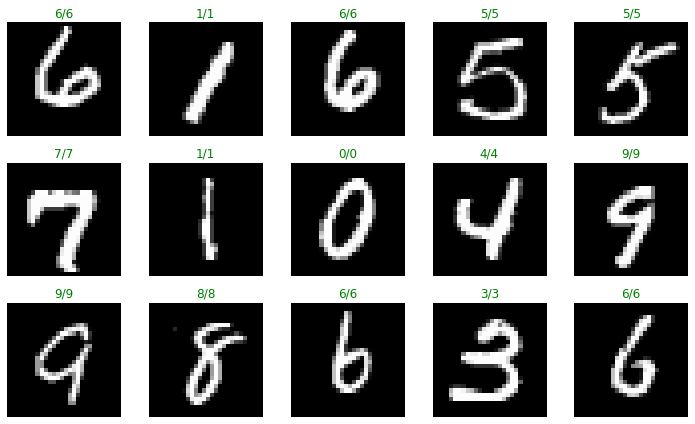

In [88]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []


for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test.iloc[ix].to_numpy()
        y_pred = evaluate([img])[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test.iloc[ix]}/{y_pred}", color="green" if y_test.iloc[ix] == y_pred else "red")
plt.tight_layout()
plt.show()

🤠 Nosso modelo é muito bom reconhecendo DÍGITOS MANUSCRITOS 

👀 Com a matriz de CONFUSÃO podemos avaliar os pontos fortes e fracos de nosso modelo.


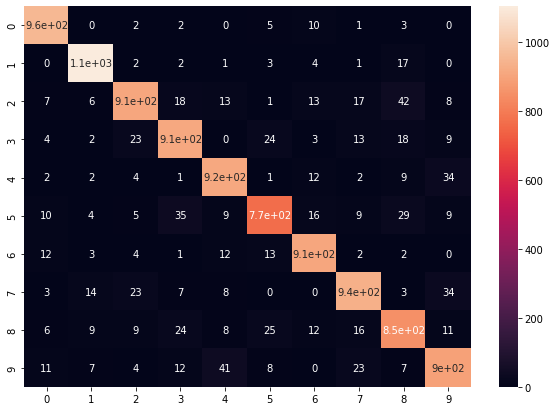

In [89]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn



y_pred = evaluate(X_test)
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in range(0,10)], columns = [i for i in range(0,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()